<a href="https://colab.research.google.com/github/melanieyes/yolov11/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam

torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

# fix seed
np.random.seed(0)

## Data

In [ ]:
batch_size = 256
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)

val_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)

train_set = CIFAR10(root="./data", train=True, download=True, transform=train_transform)

val_set = CIFAR10(root="./data", train=False, download=True, transform=val_transform)

trainloader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

testloader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
)

Files already downloaded and verified
Files already downloaded and verified


## Model

In [ ]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
from einops import rearrange, repeat
from einops.layers.torch import Rearrange


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head**-0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = (
            nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout))
            if project_out
            else nn.Identity()
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        PreNorm(
                            dim,
                            Attention(
                                dim, heads=heads, dim_head=dim_head, dropout=dropout
                            ),
                        ),
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class ViT(nn.Module):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        num_classes,
        dim,
        depth,
        heads,
        mlp_dim,
        pool="cls",
        channels=3,
        dim_head=64,
        dropout=0.0,
        emb_dropout=0.0,
    ):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert (
            image_height % patch_height == 0 and image_width % patch_width == 0
        ), "Image dimensions must be divisible by the patch size."

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {
            "cls",
            "mean",
        }, "pool type must be either cls (cls token) or mean (mean pooling)"

        self.to_patch_embedding = nn.Sequential(
            Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)",
                p1=patch_height,
                p2=patch_width,
            ),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, "() n d -> b n d", b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, : (n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == "mean" else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
model = ViT(
    image_size=32,
    patch_size=4,
    num_classes=10,
    dim=528,
    depth=4,
    heads=6,
    mlp_dim=528,
    dropout=0.1,
    emb_dropout=0.1,
).to(device)

In [ ]:
x = torch.randn(2, 3, 32, 32).to(device)
print(model(x).shape)

torch.Size([2, 10])


In [ ]:
# check parameters
n_params = sum(p.numel() for p in model.parameters())
print("number of parameters: %d" % n_params)

number of parameters: 5556154


# Train

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

In [ ]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 30

In [ ]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0  # to track number of correct predictions
    total = 0  # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        running_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)

    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(
        f"Epoch [{(epoch + 1):3}/{max_epoch:3}] \t Loss: {epoch_loss:<11.5f} Accuracy: {epoch_accuracy:.2f}% \t Test Loss: {test_loss:<11.5f} Test Accuracy: {test_accuracy:.2f}%"
    )

    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [  1/ 30] 	 Loss: 1.72349     Accuracy: 37.69% 	 Test Loss: 1.54503     Test Accuracy: 44.40%
Epoch [  2/ 30] 	 Loss: 1.50468     Accuracy: 45.61% 	 Test Loss: 1.51413     Test Accuracy: 45.17%
Epoch [  3/ 30] 	 Loss: 1.48479     Accuracy: 46.22% 	 Test Loss: 1.51876     Test Accuracy: 44.98%
Epoch [  4/ 30] 	 Loss: 1.49694     Accuracy: 45.69% 	 Test Loss: 1.47737     Test Accuracy: 45.93%
Epoch [  5/ 30] 	 Loss: 1.50158     Accuracy: 45.69% 	 Test Loss: 1.49177     Test Accuracy: 45.23%
Epoch [  6/ 30] 	 Loss: 1.52550     Accuracy: 44.39% 	 Test Loss: 1.52881     Test Accuracy: 43.99%
Epoch [  7/ 30] 	 Loss: 1.51341     Accuracy: 45.09% 	 Test Loss: 1.50316     Test Accuracy: 44.74%
Epoch [  8/ 30] 	 Loss: 1.51953     Accuracy: 44.99% 	 Test Loss: 1.50706     Test Accuracy: 44.74%
Epoch [  9/ 30] 	 Loss: 1.49880     Accuracy: 45.85% 	 Test Loss: 1.52405     Test Accuracy: 44.84%
Epoch [ 10/ 30] 	 Loss: 1.51381     Accuracy: 45.08% 	 Test Loss: 1.46999     Test Accuracy: 46.29%


In [ ]:
# the best accuracy
best_epoch = np.argmax(test_accuracies)
print(
    f"\nBest epoch: {best_epoch + 1} with test accuracy: {test_accuracies[best_epoch]:.2f}%"
)


Best epoch: 21 with test accuracy: 48.29%


# Plot results

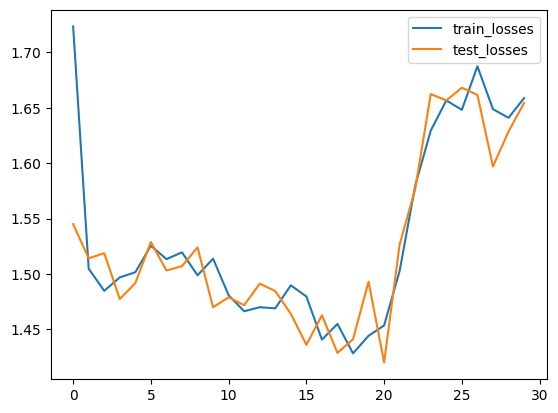

In [ ]:
plt.plot(train_losses, label="train_losses")
plt.plot(test_losses, label="test_losses")
plt.legend()

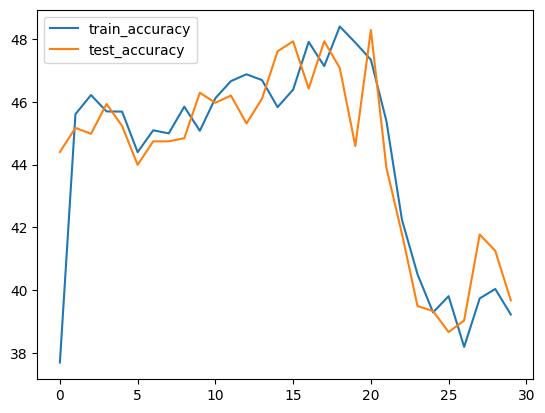

In [ ]:
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(test_accuracies, label="test_accuracy")
plt.legend()